References: https://github.com/internaut/py-lbg/tree/master

In [354]:
import random

# Dummy data from lbg_test.ipynb to check the algorithm
NUM_AREAS = 8
NUM_POINTS_PER_AREA = 10
SIZE_CODEBOOK = 8
AREA_MIN_MAX = ((-20, 20), (-20, 20))

random.seed(0)

# create random centroids for NUM_AREAS areas
area_centroids = [(random.uniform(*AREA_MIN_MAX[0]), random.uniform(*AREA_MIN_MAX[1]))
                  for _ in range(NUM_AREAS)]

# create whole population
population = []
for c in area_centroids:
    # create random points around the centroid c
    area_points = [(random.gauss(c[0], 1.0), random.gauss(c[1], 1.0)) for _ in range(NUM_POINTS_PER_AREA)]
    population.extend(area_points)

N = len(population)  # Number of data points
data = population # 2D data points
size_codebook = 8 # Size of codebook

# LBG algorithm parameters
epsilon = 0.001 # Error threshold

data

[(16.180993393300497, 8.787093524738466),
 (14.573339901295478, 8.314527600460693),
 (13.179911312916225, 11.821857000094035),
 (14.998310474078599, 9.417055967216713),
 (13.32317533087731, 10.398409160022709),
 (12.518770763277459, 10.870396122673096),
 (16.004451353072145, 8.96293462406083),
 (11.795340981448643, 10.606419863193173),
 (13.657750749917353, 12.122506049531637),
 (13.616511881944916, 10.267516403963374),
 (-3.3680106563674603, -10.633936226629766),
 (-2.504106782740814, -10.967412452753488),
 (-2.010646628527666, -9.63495380877942),
 (-2.673506710387695, -10.196094685402171),
 (-4.097330434599741, -7.843066627840166),
 (-2.7085869845134205, -8.436326808916121),
 (-2.99001386896639, -7.031722461025417),
 (-2.819636718401788, -10.673134792817862),
 (-2.4086276698120104, -9.21803087242382),
 (-5.498286740258759, -9.759234217342753),
 (1.431187875928362, -3.0014694618666544),
 (0.11155344643135295, -5.015258717030624),
 (0.9422824040517697, -4.948462447822141),
 (1.77566751

# 1. Initialization
Choose an initial codebook with a certain number of codewords.

In [355]:
# Helper functions
# Function to calculate squared Euclidean distance between two vectors
def euclid_squared(a, b):
    return sum((x_a - x_b) ** 2 for x_a, x_b in zip(a, b))

# Function to create a new codevector based on c but moved by factor e
def new_codevector(c, e):
    return [x * (1.0 + e) for x in c]

In [356]:
_size_data = len(data)
_dim = len(data[0])

# Initialize Codebook
codebook = []
codebook_abs_weights = [_size_data]
codebook_rel_weights = [1.0]

In [357]:
# Calculate initial codevector: average vector of the whole input data
c0 = [sum(vec[i] for vec in data) / _size_data for i in range(_dim)]
codebook.append(c0)
codebook

[[4.365744799505313, -1.0252245651659817]]

In [358]:
# Calculate the initial average distortion
avg_dist = sum(euclid_squared(c0, vec) for vec in data) / _size_data
avg_dist

131.83187684846615

# 2. Splitting and Merging
Splitting: for each codeword, create two new codewords by slightly perturbing the existing one
Merging: pair up existing codewords based on similarity (Euclidean distance)

# 3. Quantization
Assign each input vector to the nearest codeword in the codebook

# 4. Update Codebook
Recalculate the codewords based on assigned vectors. Repeat.

In [359]:
from functools import reduce
from collections import defaultdict

# Split codevectors until we have enough
while len(codebook) < size_codebook:
    new_codevectors = []
    for c in codebook:
        c1 = new_codevector(c, epsilon)
        c2 = new_codevector(c, -epsilon)
        new_codevectors.extend((c1, c2))

    codebook = new_codevectors
    len_codebook = len(codebook)
    abs_weights = [0] * len_codebook
    rel_weights = [0.0] * len_codebook

    avg_dist = 0
    err = epsilon + 1
    num_iter = 0
    initial_avg_dist = 0  # Initialize initial_avg_dist before the while loop
    while err > epsilon:
        closest_c_list = [None] * _size_data
        vecs_near_c = defaultdict(list)
        vec_idxs_near_c = defaultdict(list)
        for i, vec in enumerate(data):
            min_dist = None
            closest_c_index = None
            for i_c, c in enumerate(codebook):
                d = euclid_squared(vec, c)
                if min_dist is None or d < min_dist:
                    min_dist = d
                    closest_c_list[i] = c
                    closest_c_index = i_c
            vecs_near_c[closest_c_index].append(vec)
            vec_idxs_near_c[closest_c_index].append(i)

        for i_c in range(len_codebook):
            vecs = vecs_near_c.get(i_c) or []
            num_vecs_near_c = len(vecs)
            if num_vecs_near_c > 0:
                new_c = [sum(vec[i] for vec in vecs) / num_vecs_near_c for i in range(_dim)]
                codebook[i_c] = new_c
                for i in vec_idxs_near_c[i_c]:
                    closest_c_list[i] = new_c

                abs_weights[i_c] = num_vecs_near_c
                rel_weights[i_c] = num_vecs_near_c / _size_data

        prev_avg_dist = avg_dist if avg_dist > 0 else initial_avg_dist
        avg_dist = sum(euclid_squared(c_i, data[i]) for i, c_i in enumerate(closest_c_list)) / _size_data

        # Check if prev_avg_dist is not zero before performing the division
        err = (prev_avg_dist - avg_dist) / prev_avg_dist if prev_avg_dist != 0 else 1.0
        num_iter += 1

# Print the codebook
print("-" * 80)
print("Codebook:")
print("-" * 80)
for vector in codebook:
    print(vector)
print()

# Print the codebook weights
print("-" * 80)
print("Codebook weights:")
print("-" * 80)
print(abs_weights)
print(rel_weights)
print()

# Print the distortion
print("-" * 80)
print("Distortion:")
print("-" * 80)
print(avg_dist)

--------------------------------------------------------------------------------
Codebook:
--------------------------------------------------------------------------------
[13.984855614212865, 10.156871631595472]
[16.315249981754352, 0.09808785024289311]
[11.982400146480604, -8.661640742123428]
[4.545114735582526, -9.658924827886485]
[-8.394799802912065, 10.218472553062165]
[-0.7183975963278197, 3.2535477808769]
[-3.107875319457574, -9.439391295393097]
[0.31941063670964887, -4.168819471702267]

--------------------------------------------------------------------------------
Codebook weights:
--------------------------------------------------------------------------------
[10, 10, 10, 10, 10, 10, 10, 10]
[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]

--------------------------------------------------------------------------------
Distortion:
--------------------------------------------------------------------------------
1.9772335644195933


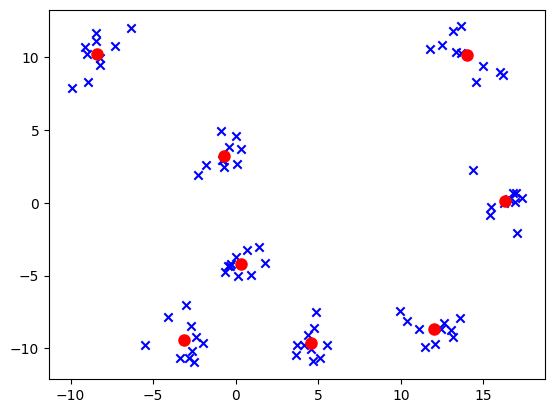

In [360]:
import matplotlib.pyplot as plt

plt.scatter([vector[0] for vector in data], [vector[1] for vector in data], marker='x', c='b')
plt.scatter([vector[0] for vector in codebook], [vector[1] for vector in codebook], s=[((w+1) ** 5) * 2 for w in codebook_rel_weights], marker='o', c='r')
plt.show()